#Домашнее задание: реализация модели latent diffusion

In [ ]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/Latent/'

##Интро
На семинарах мы познакомились с тем, как обучать диффузионную модель. Эти модели были реализованы через пиксельную диффузию, которую на практике уже никто не использует, потому что это вычислительно сложно обучить. На семинарах было разобрано обучение диффузионной модели. Для обучения вам предлагается обучение модели на датасете `nelorth/oxford-flowers` (https://huggingface.co/datasets/nelorth/oxford-flowers)  

##Цель домашнего задания
Научиться реализовать модель диффузии, модель скрытой диффузии и вносить в нее модификации.

### [5 баллов] Реализация обучения диффузионной модели на новом датасете

В этой части задания вам рекомендуется взять код с семинара и адаптировать его под обучение на новом датасете.

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели и код обучения модели.

In [ ]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
!pip install diffusers[training] -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Обучение собственной модели с помощью diffusers

Далее, мы расмотрим как можно реализовать обучение с помощью библиотеки diffusers. Для удобства мы будем использовать конфиги, группирующую все обучающие гиперпараметры. Это будет похоже на аргументы, используемые для [сценария обучения](https://github.com/huggingface/diffusers/tree/main/examples).
Здесь мы выбираем разумные значения по умолчанию для таких гиперпараметров, как `num_epochs`, `learning_rate`, `lr_warmup_steps`, но вы можете свободно настраивать их, если вы тренируетесь на своем собственном наборе данных. Например, значение `num_epochs` можно увеличить до 100 для улучшения визуального качества.

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # сгенерированное разрешение изображения
    train_batch_size = 16
    eval_batch_size = 16  # сколько изображений мы можем сэмплировать во время eval
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = 'fp16'  # `no` для float32, `fp16` для автоматической смешанной точности
    output_dir = BASE_PATH + 'ddpm-butterflies-128'  # имя модели локально и на HF Hub
    push_to_hub = False  # Если True, то загружаем сохраненную модель в HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # Если True, то перезаписываем старую модель при повторном запуске ноутбука
    seed = 0

config = TrainingConfig()

## Загрузка набора данных

Мы будем использовать библиотеку [🤗 Datasets](https://github.com/huggingface/datasets) для загрузки нашего набора данных изображений.

В этом случае [набор данных Butterflies](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) размещается удаленно, но вы можете загрузить локальную папку [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder), как показано в комментариях ниже.

In [ ]:
#!pip install datasets -q
#!pip install diffusers -q


In [ ]:
from datasets import load_dataset

#config.dataset_name = "huggan/smithsonian_butterflies_subset"
#dataset = load_dataset(config.dataset_name, split="train")

# Можно загрузить другие датасеты из https://hf.co/huggan/
# Например датасет с фотографиями цветков:
config.dataset_name = "huggan/flowers-102-categories"
dataset = load_dataset(config.dataset_name, split="train")

# Или можете загрузить свой датасет
# config.dataset_name = name
# dataset = load_dataset(config.dataset_name, data_dir=path)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8189 [00:00<?, ? examples/s]

Набор данных содержит разные признаки, но нас интересует `image`:

In [ ]:
dataset

Dataset({
    features: ['image'],
    num_rows: 8189
})

# Preprocess data

Поскольку [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) загружает изображения с помощью PIL, мы можем легко рассмотреть несколько примеров:

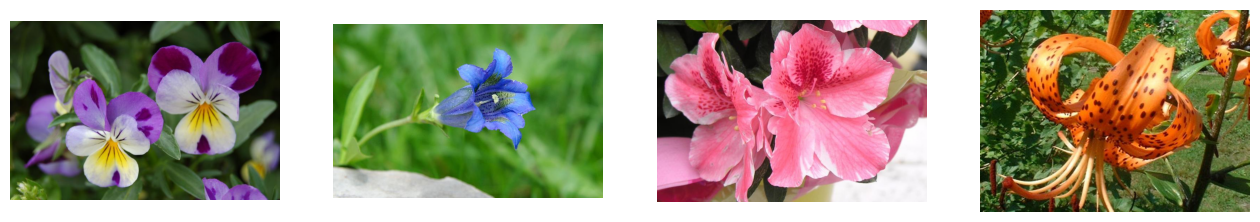

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

Все изображения в наборе данных разные, поэтому нам нужно сначала их предварительно обработать:
* `Resize` приводит изображения в соответствие с квадратным разрешением `config.image_size`.
* `RandomHorizontalFlip` дополняет набор данных, случайным образом зеркалируя изображения.
* `Normalize` важен для изменения масштаба значений пикселей в диапазон `[-1, 1]` (чего и ожидает наша модель).

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomRotation((0,8)),
        transforms.RandomAffine(degrees = 5),
        transforms.ColorJitter(),
        transforms.RandomInvert(),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

🤗 Наборы данных предлагают удобный метод set_transform() для применения преобразований изображений «на лету» во время обучения:

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

Давайте посмотрим, как они выглядят сейчас

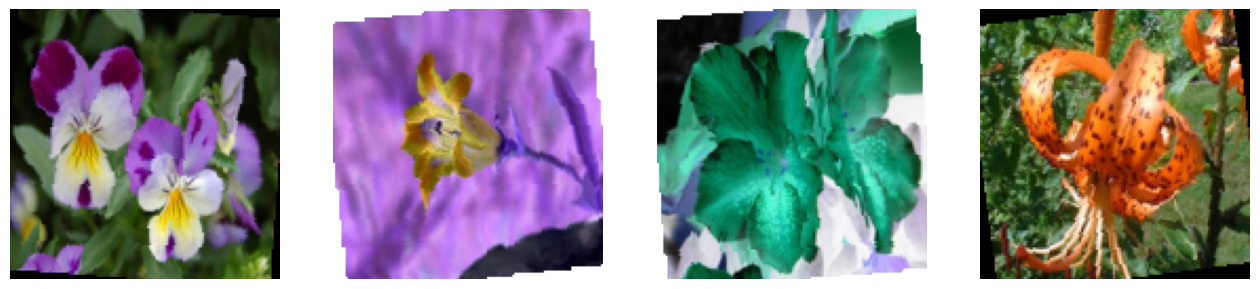

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

Теперь, когда все наши изображения имеют одинаковый размер и преобразованы в тензоры, мы можем создать dataloader, который будем использовать для обучения.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
dataiter = iter(train_dataloader)
sample = next(dataiter)
sample['images'].shape

torch.Size([16, 3, 128, 128])

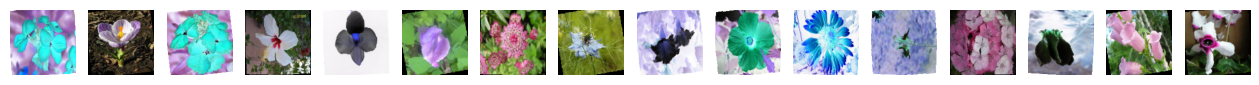

In [ ]:
fig, axs = plt.subplots(1, sample['images'].shape[0], figsize=(16, 4))
for i, image in enumerate(sample['images']):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

# Build model

In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # разрешение таргетного изображения
    in_channels=3,  # количество входных каналов, 3 для RGB изображений
    out_channels=3,  # количество выходных каналов
    layers_per_block=2,  # сколько ResNet слоев использовать для каждого UNet блока
    block_out_channels=(128, 256, 256, 512, 512, 768),  # количество выходных каналов для каждого UNet блока
    down_block_types=(
        "DownBlock2D",  # обычный ResNet блок понижения дискретизации
        #"DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # ResNet блок понижения дискретизации с самовниманием
        "DownBlock2D",
        "AttnDownBlock2D",  # ResNet блок понижения дискретизации с самовниманием
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",      # обычный ResNet блок повышения дискретизации
        "AttnUpBlock2D",  # a ResNet блок повышения дискретизации с самовниманием
        "UpBlock2D",
        "AttnUpBlock2D",  # a ResNet блок повышения дискретизации с самовниманием
        "UpBlock2D",
       # "UpBlock2D",
        "UpBlock2D"
      ),
)

In [ ]:
model.save_pretrained(BASE_PATH + 'ddpm-butterflies-128')

In [ ]:
model.from_pretrained(BASE_PATH + 'ddpm-butterflies-128')

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Dow

Давайте получим образец изображения из нашего набора данных и передадим его в нашу модель. Нам просто нужно добавить измерение партии:

In [ ]:
sample = next(dataiter)
sample_image = sample['images'][0].unsqueeze(0)#.shape
sample_image.shape


torch.Size([1, 3, 128, 128])

И давайте проверим, что на выходе получается тензор той же самой формы:

In [ ]:
model(sample_image, timestep=0).sample.shape

torch.Size([1, 3, 128, 128])

## Определение scheduler

В зависимости от алгоритма диффузии, который вы хотите использовать, способ зашумления изображений немного отличается. Вот почему 🤗 Diffusers содержит различные классы планировщика, каждый из которых определяет этапы диффузии, специфичные для алгоритма. Здесь мы собираемся использовать `DDPMScheduler`, который соответствует алгоритму шумоподавления и обучения, предложенному в [Вероятностные модели диффузии шумоподавления] (https://arxiv.org/abs/2006.11239).

In [ ]:
from diffusers import  DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Давайте посмотрим, как работает этот планировщик шума: он берет батч изображений из обучающего набора (здесь мы будем повторно использовать пакет одного изображения в форме `sample_image`), батч случайного шума той же формы и временные шаги для каждого изображения. (что соответствует количеству раз, которое мы хотим применить к каждому изображению):

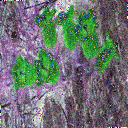

In [ ]:
#import torch
from PIL import Image
sample = next(dataiter)
sample_image = sample['images'][0].unsqueeze(0)

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

В алгоритме DDPM цель обучения модели состоит в том, чтобы иметь возможность предсказать шум, который мы использовали в `noise_scheduler.add_noise`, поэтому потери на этом этапе будут следующими:

In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
loss

tensor(1.0809, grad_fn=<MseLossBackward0>)

## Настройка обучения

У нас есть все необходимое для обучения нашей модели! Воспользуемся стандартным оптимизатором AdamW:

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

И косинусный scheduler:

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Чтобы оценить нашу модель, мы используем DDPMPipeline, который представляет собой простой способ выполнения сквозного вывода (более подробную информацию см. в этом блокноте [ссылка TODO]). Мы будем использовать этот конвейер для создания пакета образцов изображений и сохранения его в виде сетки на диск.

In [ ]:
from diffusers import DDPMPipeline
import os
import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Сэмплируем несколько изображений из случайного шума (это обратный процесс диффузии).
    # Выход пайплайна по умолчанию - `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Делаем сетку из изображений
    image_grid = make_grid(images, rows=4, cols=4)

    # Сохраняем изображения
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

В итоге мы можем сгруппировать все вместе и написать нашу обучающую функцию. Это просто завершает этап обучения, который мы видели в предыдущем разделе.

In [ ]:
model = model.to(DEVICE)

In [ ]:
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    global_step = 0

    # Теперь обучаем модель
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images'].to(DEVICE)
            # Сэмплируем шум чтобы добавить к изображениям
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Сэмплируем временной шаг для каждого изображений
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Добавляем шум к чистым изображениям в соответствии с величиной шума на каждом временном шаге
            # (это процесс прямой диффузии)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # Предсказываем остаток шума
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1

        # После каждой эпохи вы при желании можете сэмплировать несколько изображений с помощью функции evaluate() и сохранить модель.
        pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            evaluate(config, epoch, pipeline)

        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            pipeline.save_pretrained(config.output_dir)

## Давайте обучать!

Давайте запустим обучение. Перед запуском перезагрузите среду, так как у вас не хватит памяти на GPU


In [ ]:
import gc
gc.collect()

0

In [ ]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/512 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
model.save_pretrained(BASE_PATH + 'ddpm-butterflies-128')

In [ ]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

evaluate(config, 0, pipeline)

  0%|          | 0/1000 [00:00<?, ?it/s]

Давайте посмотрим на окончательную сетку изображения, созданную обученной моделью диффузии:

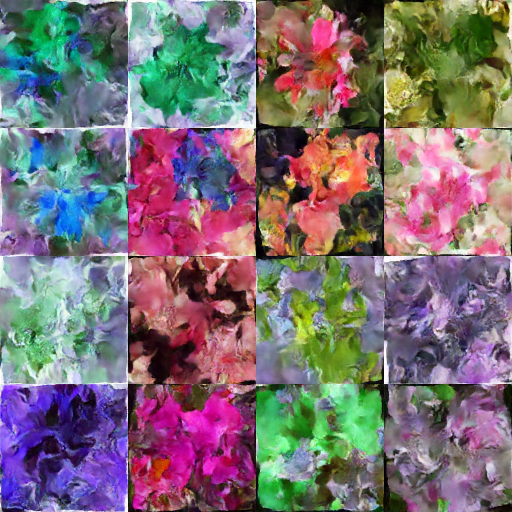

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

In [ ]:
@dataclass
class TrainingConfig:
    image_size = 128  # сгенерированное разрешение изображения
    train_batch_size = 16
    eval_batch_size = 16  # сколько изображений мы можем сэмплировать во время eval
    num_epochs = 15
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = 'fp16'  # `no` для float32, `fp16` для автоматической смешанной точности
    output_dir = BASE_PATH + 'ddpm-butterflies-128'  # имя модели локально и на HF Hub
    push_to_hub = False  # Если True, то загружаем сохраненную модель в HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # Если True, то перезаписываем старую модель при повторном запуске ноутбука
    seed = 0

config = TrainingConfig()

In [ ]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
model.save_pretrained(BASE_PATH + 'ddpm-butterflies-128')

In [ ]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

evaluate(config, 0, pipeline)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
model.save_pretrained(BASE_PATH + 'ddpm-butterflies-128')

In [ ]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

evaluate(config, 0, pipeline)

  0%|          | 0/1000 [00:00<?, ?it/s]

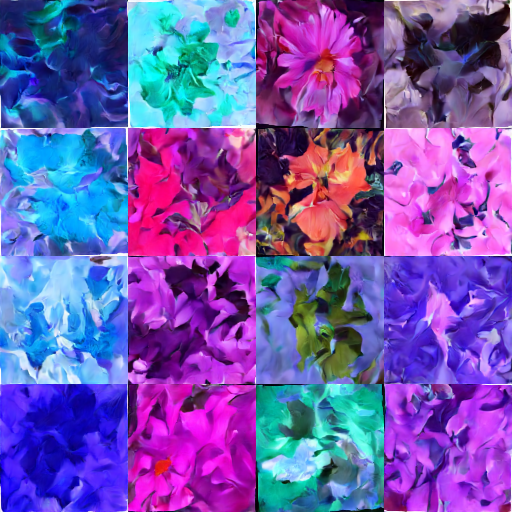

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])